In [1]:
import zipfile
with zipfile.ZipFile("EuroSAT.zip","r") as zip_ref:
    zip_ref.extractall()

In [1]:
import torch
import pandas as pd
import numpy as np
import sys, time

import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

SEED = 999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True #to make reproducible result

cuda:0


In [3]:
DIR = '2750'

# 1. ETL

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [5]:
data = datasets.ImageFolder(DIR, transform=transform)
data

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: 2750
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

# 2. EDA

In [6]:
classNames = list(data.class_to_idx)

In [7]:
def displayImage(img):
    img = img / 2 + 0.5 # denormalize image
    plt.imshow(transforms.ToPILImage()(img))

torch.Size([3, 64, 64])


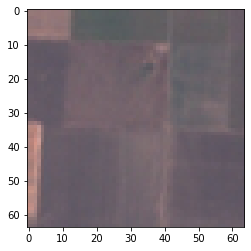

In [8]:
for temp in data:
    print(temp[0].shape)
    image = temp[0]
    displayImage(temp[0])
    break

In [9]:
def show_sample_images(dataset):
    loader = DataLoader(dataset, batch_size = 10, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = make_grid(images, nrow = 5)
    grid = grid / 2 + 0.5 # denormalize image
    im_transpose = np.transpose(grid, (1, 2, 0)) 
    plt.figure(figsize=(11, 11))
    plt.imshow(im_transpose)
    print('Encoded Labels: ', labels)
    print('Labels:')
    for label in labels:
        print(classNames[label])

Encoded Labels:  tensor([7, 9, 8, 2, 1, 7, 9, 1, 0, 0])
Labels:
Residential
SeaLake
River
HerbaceousVegetation
Forest
Residential
SeaLake
Forest
AnnualCrop
AnnualCrop


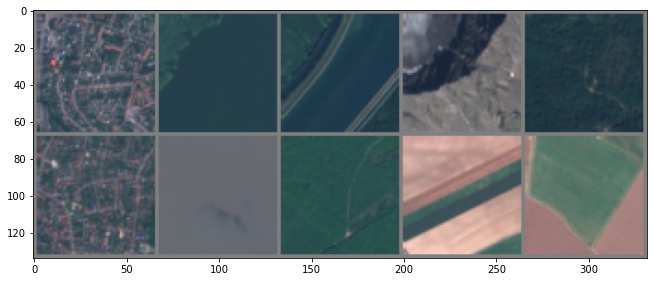

In [10]:
show_sample_images(data)

In [11]:
# getting labels/targets
classNames = list(data.class_to_idx)
classNames

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

## Checking if dataset is balanced

In [12]:
# counting no. of each label
labels, noOfImagesPerClass = torch.unique(torch.tensor(data.targets), return_counts=True)

In [13]:
classCount =  pd.DataFrame({'class': labels, 'count': noOfImagesPerClass})

In [14]:
classCount

class  count
0      0   3000
1      1   3000
2      2   3000
3      3   2500
4      4   2500
5      5   2000
6      6   2500
7      7   3000
8      8   2500
9      9   3000

In [15]:
for index, i in enumerate(range(len(noOfImagesPerClass))):
    print(f"{index} {classNames[i]}: {noOfImagesPerClass[i]}")

0 AnnualCrop: 3000
1 Forest: 3000
2 HerbaceousVegetation: 3000
3 Highway: 2500
4 Industrial: 2500
5 Pasture: 2000
6 PermanentCrop: 2500
7 Residential: 3000
8 River: 2500
9 SeaLake: 3000


<AxesSubplot:xlabel='class', ylabel='count'>

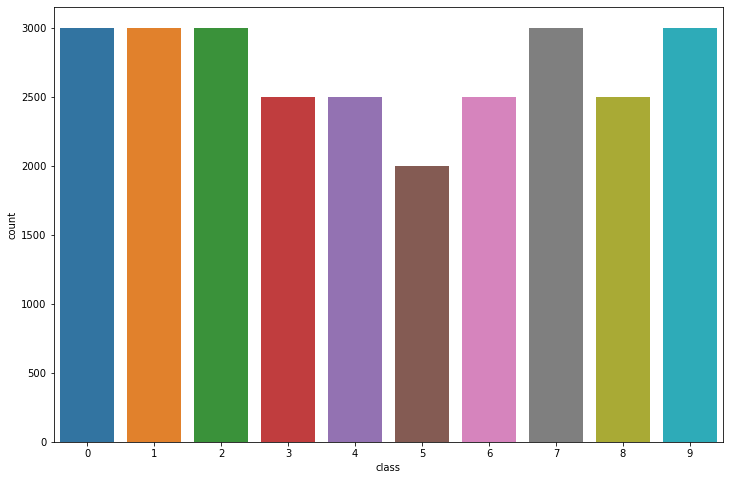

In [16]:
plt.figure(figsize=(12, 8))
sns.barplot(x = 'class', y='count', data = classCount)

In [17]:
len(data)

27000

In [19]:
train_set, test_set = torch.utils.data.random_split(data, [21600, 5400])  # test set 20 percent
train_set, val_set = torch.utils.data.random_split(train_set, [16200, 5400]) # valid set 20 percent

In [20]:
batch_size = 50

train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)
# val_loader = DataLoader(val_set, len(val_set), shuffle=True)
# test_loader = DataLoader(test_set, len(test_set), shuffle=True)
val_loader = DataLoader(val_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)

# 3. Create Model

## Model 1: Base CNN Model

In [20]:
class EuroCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Conv2d(3, 128, 3, 1)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.linear = nn.Linear(128*31*31, 10)
        self.relu    = nn.ReLU()
        self.dropoutLayer = nn.Dropout(p=0.2)
        # self.relu    = nn.ReLU()
    
    def forward(self, image):
        out = self.conv(image) 
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(-1, 128*31*31)
        out = self.dropoutLayer(out)
        out = self.linear(out)
        return out

## Model 2: Deeper CNN Model

In [21]:
class deepEuroCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 128, 3, 1, 0)
        self.batchNorm1 = nn.BatchNorm2d(num_features=128)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(128, 256, 3, 1, 0)
        self.batchNorm2 = nn.BatchNorm2d(num_features=256)
        
        self.linear1 = nn.Linear(256*14*14, 100)
        self.linear2 = nn.Linear(100, 50)
        self.linear3 = nn.Linear(50, 10)
        self.relu    = nn.ReLU()
        self.dropoutLayer = nn.Dropout(p=0.2)
    
    def forward(self, image):
        out = self.conv1(image) 
        out = self.relu(out)
        out = self.batchNorm1(out)
        out = self.maxpool(out)
        
        out = self.conv2(out) 
        out = self.relu(out)
        out = self.batchNorm2(out)
        out = self.maxpool(out)
        
        out = out.reshape(-1, 256*14*14)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.dropoutLayer(out)
        
        out = self.linear2(out)
        out = self.relu(out)
        out = self.dropoutLayer(out)
        
        out = self.linear3(out)
        return out

In [22]:
## Model 3: More Deeper CNN Model

In [23]:
class deeperEuroCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 0)
        self.batchNorm1 = nn.BatchNorm2d(num_features=64)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 0)
        self.batchNorm2 = nn.BatchNorm2d(num_features=128)
        
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 0)
        self.batchNorm3 = nn.BatchNorm2d(num_features=256)
        
        
        self.linear1 = nn.Linear(256*6*6, 200)
        self.linear2 = nn.Linear(200, 100)
        self.linear3 = nn.Linear(100, 75)
        self.linear4 = nn.Linear(75, 10)
        self.relu    = nn.ReLU()
        self.dropoutLayer = nn.Dropout(p=0.2)
    
    def forward(self, image):
        out = self.conv1(image) 
        out = self.relu(out)
        out = self.batchNorm1(out)
        out = self.maxpool(out)
        
        out = self.conv2(out) 
        out = self.relu(out)
        out = self.batchNorm2(out)
        out = self.maxpool(out)
        
        out = self.conv3(out) 
        out = self.relu(out)
        out = self.batchNorm3(out)
        out = self.maxpool(out)
        
        out = out.reshape(-1, 256*6*6)
        out = self.dropoutLayer(out)
        
        out = self.linear1(out)
        out = self.relu(out)
        out = self.dropoutLayer(out)
        
        out = self.linear2(out)
        out = self.relu(out)
        out = self.dropoutLayer(out)
        
        out = self.linear3(out)
        out = self.relu(out)
        out = self.dropoutLayer(out)
        
        out = self.linear4(out)
        return out

# 4. Train Model

## Train Model 1

In [24]:
baseModel = EuroCNN().to(device)

In [25]:
print(baseModel)

EuroCNN(
  (conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=123008, out_features=10, bias=True)
  (relu): ReLU()
  (dropoutLayer): Dropout(p=0.2, inplace=False)
)


## Model Parameters

In [26]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [27]:
count_parameters(baseModel)

  3456
   128
1230080
    10
______
1233674


## Test Model

In [28]:
random_image = torch.rand((50, 3, 64, 64)).to(device)
out = baseModel(random_image)
print(out.shape)

torch.Size([50, 10])


## Loss function and optimizer

In [29]:
J_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseModel.parameters(), lr=0.001)

## Train Model

In [21]:
class EarlyStopping():
    def __init__(self, patience, threshold):
        self.patience      = 5
        self.threshold     = 0.1
        self.prev_val_loss = None
        self.patienceCount = 0
        
    def _checkPatience(self,):
        if self.patienceCount == self.patience:
            return True
        else:
            self.patienceCount += 1
            return False
    
    def checkCondition(self, val_loss):
        if self.prev_val_loss == None:
            self.prev_val_loss = val_loss
        elif val_loss - self.prev_val_loss > self.threshold:
            return self._checkPatience()
        
        self.patienceCount = 0
        return False

In [22]:
def train(model, optimizer, J_fn, filepath, epochs=10, patience = 5, threshold = 0.1):
    
    earlyStopping = EarlyStopping(patience, threshold)
    
    val_old_loss = float("Inf")
    train_losses = []
    train_accs   = []
    avg_train_losses_per_epoch = []
    avg_train_accs_per_epoch   = []
    val_losses   = []
    val_accs     = []
    training_time = []
    training_time_per_epoch = []
    
    for e in range(epochs):
        total_corr       = 0
        total_loss       = 0
        total_train_loss = 0
        total_time_epoch = 0
        for b, (image, label) in enumerate(train_loader):
            start_time = time.time()

            image = image.to(device)
            label = label.to(device)

            yhat = model(image)
            train_loss = J_fn(yhat, label)
            total_train_loss += train_loss

            train_losses.append(train_loss)
            predicted = torch.max(yhat, 1)[1]
            batch_corr = (predicted == label).sum()
            total_corr += batch_corr

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            train_acc = (total_corr * 100) / (batch_size * (b + 1))
            train_accs.append(train_acc)

            total_time = time.time() - start_time
            total_time_epoch += total_time
            training_time.append(total_time)

            if (b+1) % 64 == 0:
                print(f"Epoch: {e + 1} - Batch: {b + 1} - Train Loss: {train_loss:.2f} - Train Acc: {train_acc:.2f} - Total Time: {total_time:.2f}s")
                # print("Loss Gradient for first Conv Layer: ", torch.mean(model.conv1.weight.grad) )
        
        avg_train_time = total_time_epoch / len(train_loader)
        training_time_per_epoch.append(avg_train_time)
        
        avg_train_loss = total_train_loss / len(train_loader)   
        avg_train_acc  = (total_corr * 100) / len(train_set)
        
        avg_train_losses_per_epoch.append(avg_train_loss)
        avg_train_accs_per_epoch.append(avg_train_acc)
        
        print(f"++++++End of Epoch {e + 1} ++++++ Avg Train Loss: {avg_train_loss:.2f} - Avg Train Acc: {avg_train_acc:.2f} - Avg Train Time: {avg_train_time:.2f}")

        with torch.no_grad():
            val_corr       = 0 
            total_val_loss = 0
            for val_image, val_label in val_loader:
                val_image = val_image.to(device)
                val_label = val_label.to(device)
                val_yhat = model(val_image)
                val_loss = J_fn(val_yhat, val_label)
                total_val_loss += val_loss
                val_predicted = torch.max(val_yhat, 1)[1]
                val_corr += (val_predicted == val_label).sum()
            val_acc = (val_corr * 100) / len(val_set)
            avg_val_loss = total_val_loss / len(val_loader)
            val_accs.append(val_acc)
            val_losses.append(val_loss)
            
            if avg_val_loss < val_old_loss:
                val_old_loss = avg_val_loss
                saveObject = {
                    'epoch': e + 1,
                    'batch': b + 1,
                    'train_loss': avg_train_loss,
                    'train_acc': avg_train_acc,
                    'val_loss': avg_val_loss,
                    'val_acc': val_acc,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }
                torch.save(saveObject, filepath)
            
        if earlyStopping.checkCondition(avg_val_loss):
            break
            
        print(f"++++++Validation++++++ Val Loss: {avg_val_loss:.2f} - Val Acc: {val_acc:.2f}")
        
        
    return train_losses, avg_train_losses_per_epoch, train_accs, avg_train_accs_per_epoch, training_time, training_time_per_epoch, val_losses, val_accs

In [32]:
filepath = 'bestmodel1.pt'

In [33]:
train_losses, avg_train_losses_per_epoch, train_accs, avg_train_accs_per_epoch, training_time, training_time_per_epoch, val_losses, val_accs = train(baseModel, optimizer, J_fn, filepath, 20)

Epoch: 1 - Batch: 64 - Train Loss: 1.30 - Train Acc: 40.97 - Total Time: 0.01s
Epoch: 1 - Batch: 128 - Train Loss: 0.84 - Train Acc: 51.01 - Total Time: 0.00s
Epoch: 1 - Batch: 192 - Train Loss: 0.88 - Train Acc: 55.31 - Total Time: 0.00s
Epoch: 1 - Batch: 256 - Train Loss: 0.64 - Train Acc: 58.26 - Total Time: 0.01s
++++++End of Epoch 1 ++++++ Avg Train Loss: 1.52 - Avg Train Acc: 58.74 - Avg Train Time: 0.00
++++++Validation++++++ Val Loss: 0.86 - Val Acc: 72.13
Epoch: 2 - Batch: 64 - Train Loss: 0.79 - Train Acc: 74.66 - Total Time: 0.01s
Epoch: 2 - Batch: 128 - Train Loss: 0.92 - Train Acc: 74.57 - Total Time: 0.00s
Epoch: 2 - Batch: 192 - Train Loss: 0.77 - Train Acc: 75.50 - Total Time: 0.00s
Epoch: 2 - Batch: 256 - Train Loss: 0.73 - Train Acc: 75.45 - Total Time: 0.00s
++++++End of Epoch 2 ++++++ Avg Train Loss: 0.73 - Avg Train Acc: 75.39 - Avg Train Time: 0.00
++++++Validation++++++ Val Loss: 0.71 - Val Acc: 77.15
Epoch: 3 - Batch: 64 - Train Loss: 0.39 - Train Acc: 83.23 - T

## Plotting loss

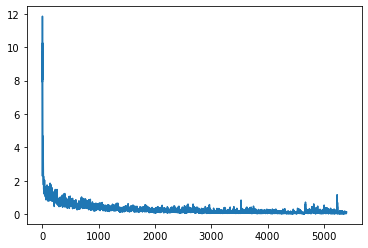

In [34]:
plt.plot(torch.Tensor(train_losses).cpu())

In [35]:
def plotLoss(trainingLoss, valLoss):
    plt.plot(trainingLoss)
    plt.plot(valLoss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training Loss", "Val Loss"])

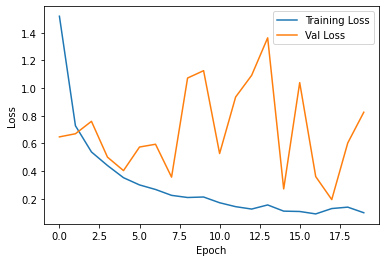

In [36]:
plotLoss(torch.Tensor(avg_train_losses_per_epoch).cpu(), torch.Tensor(val_losses).cpu())

## Plotting accuracy

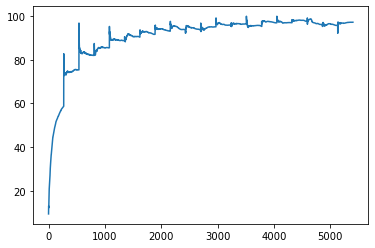

In [37]:
plt.plot(torch.Tensor(train_accs).cpu())

In [38]:
def plotAccuracy(trainingAcc, valAcc):
    plt.plot(trainingAcc)
    plt.plot(valAcc)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(["Training Accuracy", "Val Accuracy"])

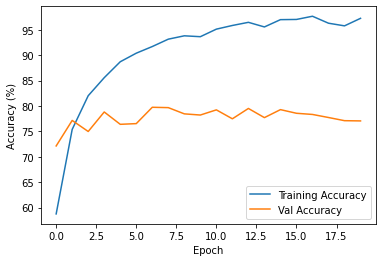

In [39]:
plotAccuracy(torch.Tensor(avg_train_accs_per_epoch).cpu(), torch.Tensor(val_accs).cpu())

## Plotting training time

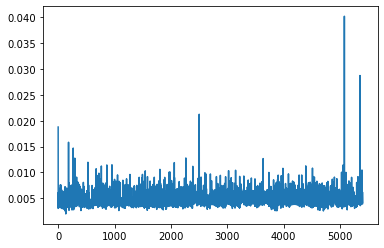

In [40]:
plt.plot(torch.Tensor(training_time).cpu())

In [41]:
def plotTrainingTime(training_time):
    plt.plot(training_time)
    plt.xlabel("Epoch")
    plt.ylabel("Training Time (s)")

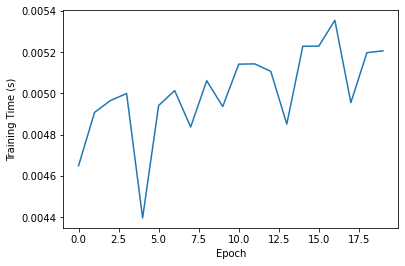

In [42]:
plotTrainingTime(training_time_per_epoch)

In [43]:
saveObject = {
    'train_losses': train_losses,
    'avg_train_losses_per_epoch': avg_train_losses_per_epoch,
    'train_accs': train_accs,
    'avg_train_accs_per_epoch': avg_train_accs_per_epoch,
    'training_time': training_time,
    'training_time_per_epoch': training_time_per_epoch,
    'val_losses': val_losses,
    'val_accs': val_accs
}

torch.save(saveObject, 'baseModeltrainingHist.pt')

## Plot from saved file

In [44]:
loadObject1 = torch.load('baseModeltrainingHist.pt')

## Potting loss

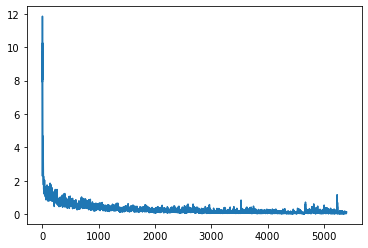

In [45]:
plt.plot(torch.Tensor(loadObject1['train_losses']).cpu())

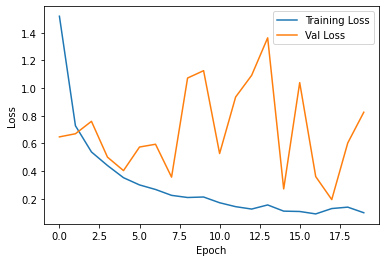

In [46]:
plotLoss(torch.Tensor(loadObject1['avg_train_losses_per_epoch']).cpu(), torch.Tensor(loadObject1['val_losses']).cpu())

## Plotting accuracy

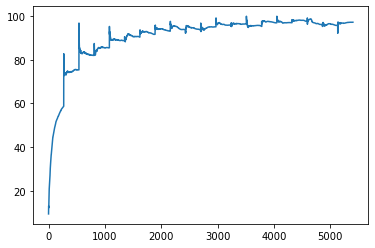

In [47]:
plt.plot(torch.Tensor(loadObject1['train_accs']).cpu())

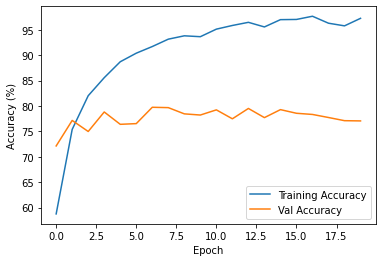

In [48]:
plotAccuracy(torch.Tensor(loadObject1['avg_train_accs_per_epoch']).cpu(), torch.Tensor(loadObject1['val_accs']).cpu())

## Plotting training time

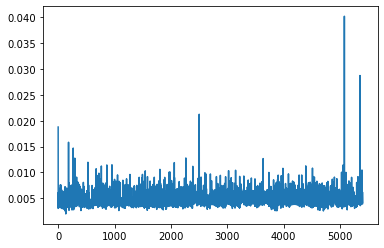

In [49]:
plt.plot(torch.Tensor(loadObject1['training_time']).cpu())

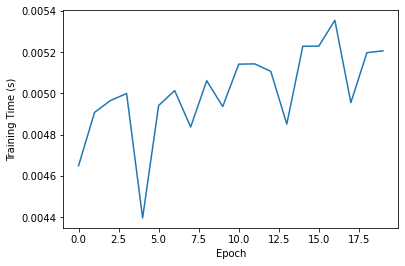

In [50]:
plotTrainingTime(loadObject1['training_time_per_epoch'])

# Train Model 2

In [51]:
model2 = deepEuroCNN().to(device)

In [52]:
print(model2)

deepEuroCNN(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=50176, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
  (dropoutLayer): Dropout(p=0.2, inplace=False)
)


## Model Parameters

In [53]:
count_parameters(model2)

  3456
   128
   128
   128
294912
   256
   256
   256
5017600
   100
  5000
    50
   500
    10
______
5322780


## Test Model

In [54]:
random_image = torch.rand((50, 3, 64, 64)).to(device)
out = model2(random_image)
print(out.shape)

torch.Size([50, 10])


## Loss function and optimizer

In [55]:
J_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

## Train Model

In [56]:
filepath2 = 'bestModel2Para.pt'

In [57]:
train_losses2, avg_train_losses_per_epoch2, train_accs2, avg_train_accs_per_epoch2, training_time2, training_time_per_epoch2, val_losses2, val_accs2 = train(model2, optimizer, J_fn, filepath2, 20)

Epoch: 1 - Batch: 64 - Train Loss: 1.90 - Train Acc: 42.38 - Total Time: 0.02s
Epoch: 1 - Batch: 128 - Train Loss: 1.11 - Train Acc: 49.21 - Total Time: 0.02s
Epoch: 1 - Batch: 192 - Train Loss: 1.28 - Train Acc: 53.69 - Total Time: 0.02s
Epoch: 1 - Batch: 256 - Train Loss: 1.08 - Train Acc: 56.89 - Total Time: 0.01s
++++++End of Epoch 1 ++++++ Avg Train Loss: 1.33 - Avg Train Acc: 57.59 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 0.85 - Val Acc: 71.32
Epoch: 2 - Batch: 64 - Train Loss: 1.07 - Train Acc: 72.19 - Total Time: 0.02s
Epoch: 2 - Batch: 128 - Train Loss: 1.30 - Train Acc: 71.56 - Total Time: 0.01s
Epoch: 2 - Batch: 192 - Train Loss: 0.77 - Train Acc: 72.69 - Total Time: 0.02s
Epoch: 2 - Batch: 256 - Train Loss: 0.77 - Train Acc: 73.48 - Total Time: 0.02s
++++++End of Epoch 2 ++++++ Avg Train Loss: 0.79 - Avg Train Acc: 73.51 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 0.73 - Val Acc: 75.21
Epoch: 3 - Batch: 64 - Train Loss: 0.77 - Train Acc: 76.93 - T

## Plotting loss

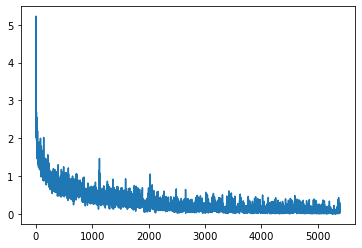

In [58]:
plt.plot(torch.Tensor(train_losses2).cpu())

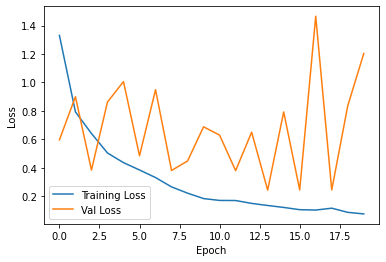

In [59]:
plotLoss(torch.Tensor(avg_train_losses_per_epoch2).cpu(), torch.Tensor(val_losses2).cpu())

## Plotting accuracy

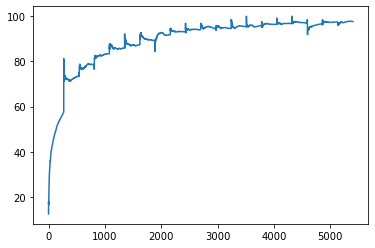

In [60]:
plt.plot(torch.Tensor(train_accs2).cpu())

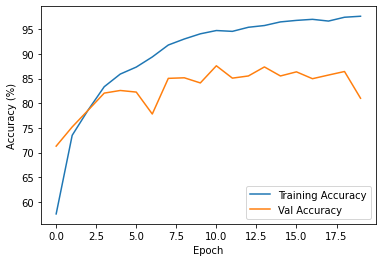

In [61]:
plotAccuracy(torch.Tensor(avg_train_accs_per_epoch2).cpu(), torch.Tensor(val_accs2).cpu())

## Plotting training time

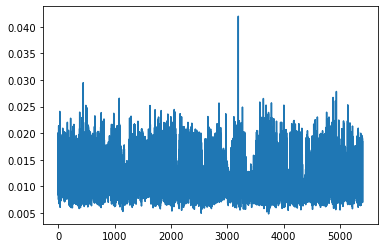

In [62]:
plt.plot(torch.Tensor(training_time2).cpu())

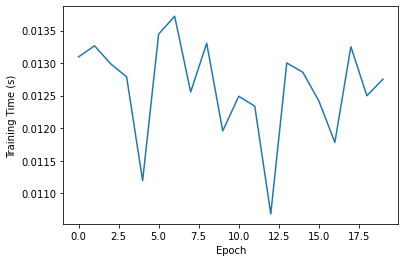

In [63]:
plotTrainingTime(training_time_per_epoch2)

In [64]:
saveObject = {
    'train_losses': train_losses2,
    'avg_train_losses_per_epoch': avg_train_losses_per_epoch2,
    'train_accs': train_accs2,
    'avg_train_accs_per_epoch': avg_train_accs_per_epoch2,
    'training_time': training_time2,
    'training_time_per_epoch': training_time_per_epoch2,
    'val_losses': val_losses2,
    'val_accs': val_accs2
}

torch.save(saveObject, 'Model2TrainingHist')

# Train Model 3

In [65]:
model3 = deeperEuroCNN().to(device)

In [66]:
print(model3)

deeperEuroCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=9216, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=75, bias=True)
  (linear4): Linear(in_features=75, out_features=10, bias=True)
  (relu): ReLU()
  (dropoutLayer): Dropout(p=0.2, inplace=False)
)


## Model Parameters

In [67]:
count_parameters(model3)

  1728
    64
    64
    64
 73728
   128
   128
   128
294912
   256
   256
   256
1843200
   200
 20000
   100
  7500
    75
   750
    10
______
2243547


## Test Model

In [68]:
random_image = torch.rand((50, 3, 64, 64)).to(device)
out = model3(random_image)
print(out.shape)

torch.Size([50, 10])


## Loss function and optimizer

In [69]:
J_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

## Train Model

In [70]:
filepath3 = 'bestModel3Para.pt'

In [71]:
train_losses3, avg_train_losses_per_epoch3, train_accs3, avg_train_accs_per_epoch3, training_time3, training_time_per_epoch3, val_losses3, val_accs3 = train(model3, optimizer, J_fn, filepath3, 20)

Epoch: 1 - Batch: 64 - Train Loss: 1.23 - Train Acc: 46.61 - Total Time: 0.01s
Epoch: 1 - Batch: 128 - Train Loss: 1.55 - Train Acc: 54.26 - Total Time: 0.01s
Epoch: 1 - Batch: 192 - Train Loss: 0.61 - Train Acc: 58.67 - Total Time: 0.01s
Epoch: 1 - Batch: 256 - Train Loss: 0.71 - Train Acc: 61.80 - Total Time: 0.01s
++++++End of Epoch 1 ++++++ Avg Train Loss: 1.07 - Avg Train Acc: 62.33 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 0.79 - Val Acc: 73.06
Epoch: 2 - Batch: 64 - Train Loss: 0.60 - Train Acc: 75.44 - Total Time: 0.01s
Epoch: 2 - Batch: 128 - Train Loss: 0.64 - Train Acc: 75.61 - Total Time: 0.01s
Epoch: 2 - Batch: 192 - Train Loss: 0.30 - Train Acc: 76.40 - Total Time: 0.01s
Epoch: 2 - Batch: 256 - Train Loss: 0.58 - Train Acc: 76.86 - Total Time: 0.01s
++++++End of Epoch 2 ++++++ Avg Train Loss: 0.69 - Avg Train Acc: 76.96 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 0.64 - Val Acc: 78.75
Epoch: 3 - Batch: 64 - Train Loss: 0.56 - Train Acc: 79.98 - T

## Plotting loss

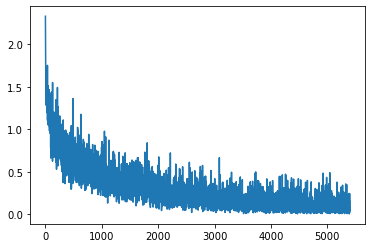

In [72]:
plt.plot(torch.Tensor(train_losses3).cpu())

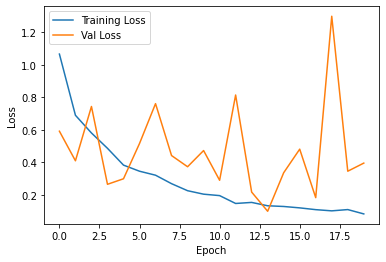

In [73]:
plotLoss(torch.Tensor(avg_train_losses_per_epoch3).cpu(), torch.Tensor(val_losses3).cpu())

## Plotting accuracy

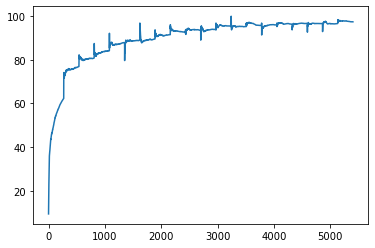

In [74]:
plt.plot(torch.Tensor(train_accs3).cpu())

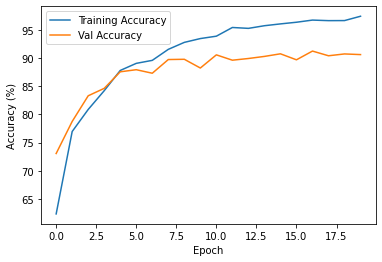

In [75]:
plotAccuracy(torch.Tensor(avg_train_accs_per_epoch3).cpu(), torch.Tensor(val_accs3).cpu())

## Plotting training time

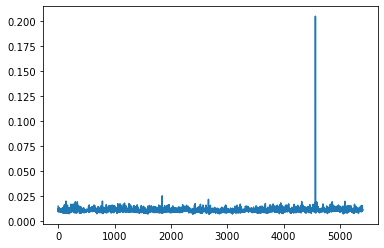

In [76]:
plt.plot(torch.Tensor(training_time3).cpu())

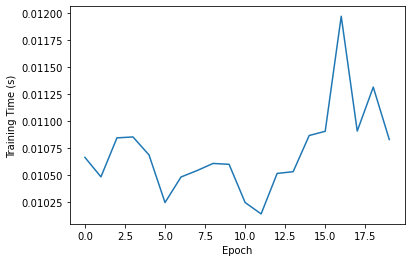

In [77]:
plotTrainingTime(training_time_per_epoch3)

In [78]:
saveObject = {
    'train_losses': train_losses3,
    'avg_train_losses_per_epoch': avg_train_losses_per_epoch3,
    'train_accs': train_accs3,
    'avg_train_accs_per_epoch': avg_train_accs_per_epoch3,
    'training_time': training_time3,
    'training_time_per_epoch': training_time_per_epoch3,
    'val_losses': val_losses3,
    'val_accs': val_accs3
}

torch.save(saveObject, 'Model3TrainingHist')

## Comparison of Three Models

## Training Loss plot

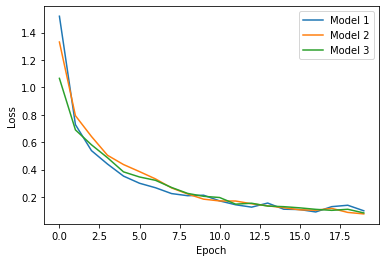

In [79]:
plt.plot(torch.Tensor(avg_train_losses_per_epoch).cpu())
plt.plot(torch.Tensor(avg_train_losses_per_epoch2).cpu())
plt.plot(torch.Tensor(avg_train_losses_per_epoch3).cpu())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Model 1", "Model 2", "Model 3"])

## Validation Loss Plot

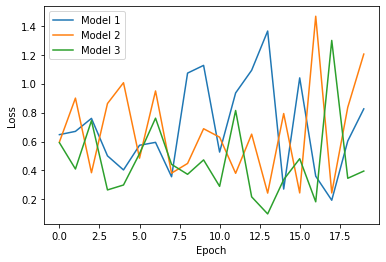

In [80]:
plt.plot(torch.Tensor(val_losses).cpu())
plt.plot(torch.Tensor(val_losses2).cpu())
plt.plot(torch.Tensor(val_losses3).cpu())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Model 1", "Model 2", "Model 3"])

## Accuracy Plot (Training data)

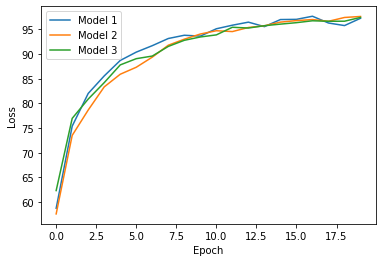

In [81]:
plt.plot(torch.Tensor(avg_train_accs_per_epoch).cpu())
plt.plot(torch.Tensor(avg_train_accs_per_epoch2).cpu())
plt.plot(torch.Tensor(avg_train_accs_per_epoch3).cpu())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Model 1", "Model 2", "Model 3"])

## Accuracy Plot (Validation data)

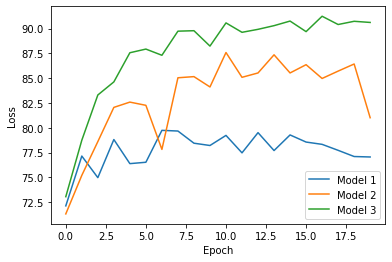

In [82]:
plt.plot(torch.Tensor(val_accs).cpu())
plt.plot(torch.Tensor(val_accs2).cpu())
plt.plot(torch.Tensor(val_accs3).cpu())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Model 1", "Model 2", "Model 3"])

# 5. Test

In [83]:
checkpoint1 = torch.load(filepath)
checkpoint2 = torch.load(filepath2)
checkpoint3 = torch.load(filepath3)

In [84]:
bestModel1 = EuroCNN().to(device)
bestModel2 = deepEuroCNN().to(device)
bestModel3 = deeperEuroCNN().to(device)

In [85]:
bestModel1.load_state_dict(checkpoint1['model_state_dict'])
bestModel2.load_state_dict(checkpoint2['model_state_dict'])
bestModel3.load_state_dict(checkpoint3['model_state_dict'])

<All keys matched successfully>

In [86]:
bestModel1.eval()
bestModel2.eval()
bestModel3.eval()

deeperEuroCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=9216, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=75, bias=True)
  (linear4): Linear(in_features=75, out_features=10, bias=True)
  (relu): ReLU()
  (dropoutLayer): Dropout(p=0.2, inplace=False)
)

In [23]:
def testModel(model):
    with torch.no_grad():
        correct = 0
        acc     = 0
        total   = 0
        allPrediction       = []
        correctLabels       = []
        misclassifiedLabels = []
        
        for images, targets in test_loader:
            images  = images.to(device)
            targets = targets.to(device)                  

            yhat    = model(images)
            predicted = torch.max(yhat, 1)[1] 
            batch_corr = (predicted == targets).sum()
            correct   += batch_corr
            total     += targets.shape[0]
            
            for i in range(len(predicted)):
                if predicted[i] != targets[i]:
                    misclassifiedLabels.append({
                        'correctLabel': targets[i],
                        'predicted': predicted[i],
                        'image': images[i]
                    })

            allPrediction.append(predicted)
            correctLabels.append(targets)

        acc = 100 * correct / total
        print(f"Accuracy: {acc:.2f}")
        
        return allPrediction, correctLabels, misclassifiedLabels

## Accuracy of Model 1

In [88]:
allPrediction1, correctLabels1, misclassifiedLabels1 = testModel(bestModel1)

Accuracy: 78.19


## Accuracy of Model 2

In [89]:
allPrediction2, correctLabels2, misclassifiedLabels2 = testModel(bestModel2)

Accuracy: 88.59


## Accuracy of Model 3

In [90]:
allPrediction3, correctLabels3, misclassifiedLabels3 = testModel(bestModel3)

Accuracy: 91.59


## Display Confusion Matrix

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Model 1

In [92]:
allPredictionTensor1 = allPrediction1[0]
correctLabelsTensor1 = correctLabels1[0]

In [93]:
for i in range(1, len(allPrediction1)):
    allPredictionTensor1 = torch.cat((allPredictionTensor1, allPrediction1[i]))
    
for i in range(1, len(correctLabels1)):
    correctLabelsTensor1 = torch.cat((correctLabelsTensor1, correctLabels1[i]))

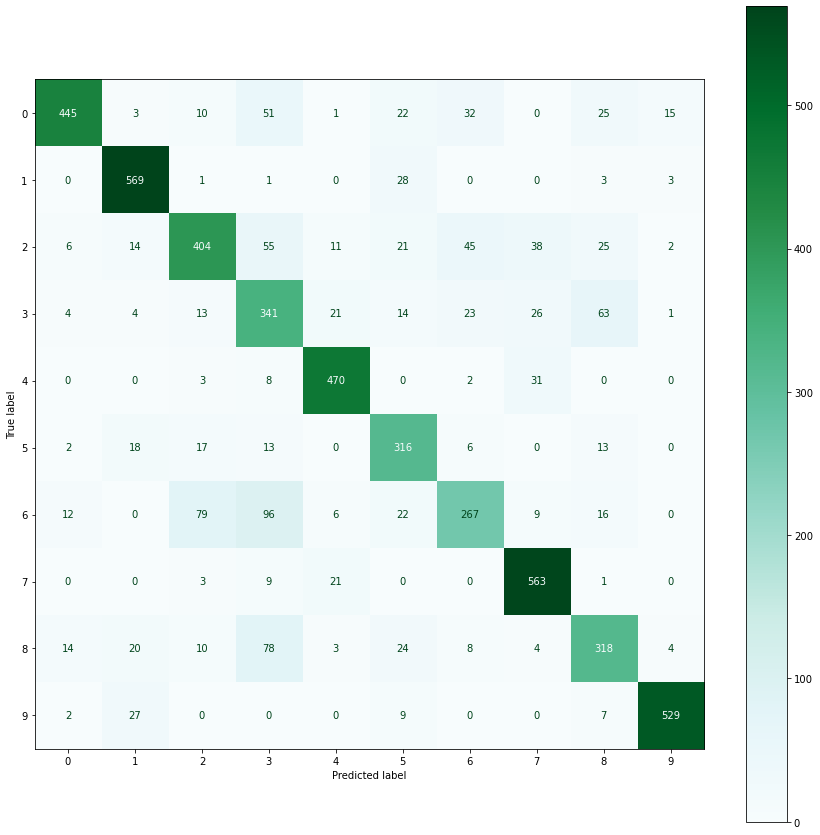

In [94]:
confusion_matrix_report1 = confusion_matrix(correctLabelsTensor1.cpu(), allPredictionTensor1.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix_report1)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap='BuGn')

## Model 2

In [95]:
allPredictionTensor2 = allPrediction2[0]
correctLabelsTensor2 = correctLabels2[0]

In [96]:
for i in range(1, len(allPrediction2)):
    allPredictionTensor2 = torch.cat((allPredictionTensor2, allPrediction2[i]))
    
for i in range(1, len(correctLabels2)):
    correctLabelsTensor2 = torch.cat((correctLabelsTensor2, correctLabels2[i]))

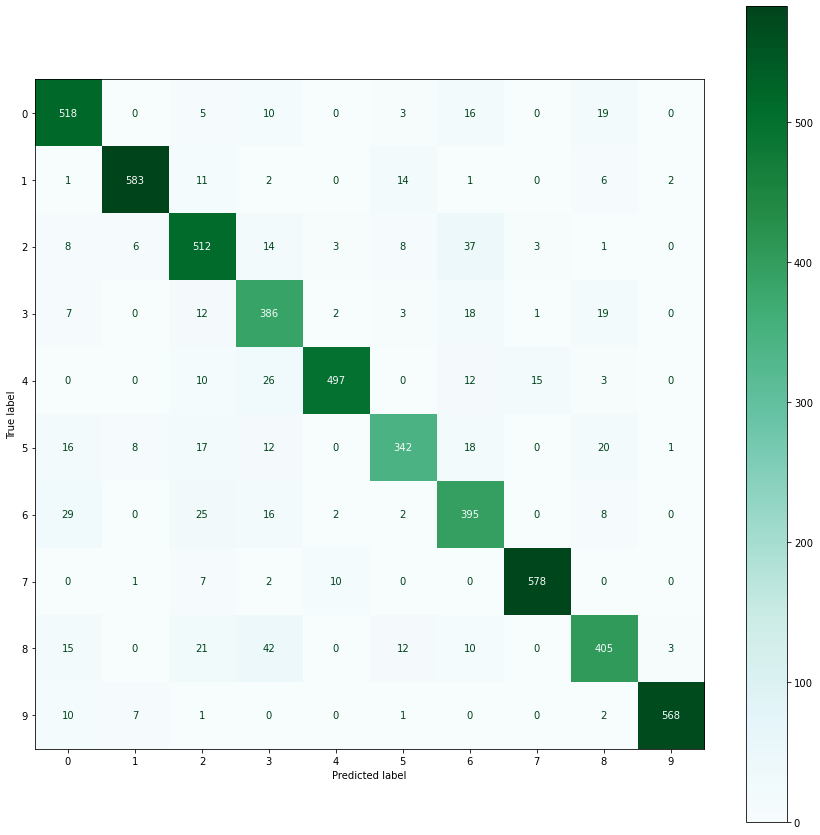

In [97]:
confusion_matrix_report2 = confusion_matrix(allPredictionTensor2.cpu(), correctLabelsTensor2.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix_report2)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap='BuGn')

## Model 3

In [98]:
allPredictionTensor3 = allPrediction3[0]
correctLabelsTensor3 = correctLabels3[0]

In [99]:
for i in range(1, len(allPrediction3)):
    allPredictionTensor3 = torch.cat((allPredictionTensor3, allPrediction3[i]))
    
for i in range(1, len(correctLabels3)):
    correctLabelsTensor3 = torch.cat((correctLabelsTensor3, correctLabels3[i]))

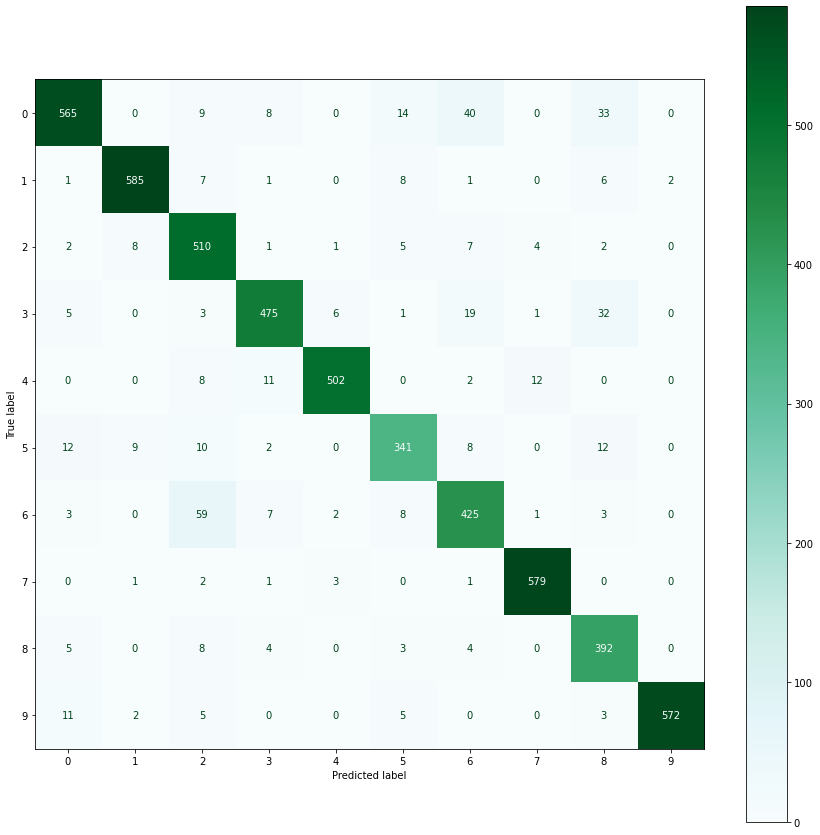

In [100]:
confusion_matrix_report3 = confusion_matrix(allPredictionTensor3.cpu(), correctLabelsTensor3.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix_report3)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap='BuGn')

## Examined Misclassified Images

In [24]:
def count_misclassified_images_per_label(confusion_matrix_report):
    total_number_misclassified_labels = []
    misclassified_labels_percentage   = []
    for i in range(len(confusion_matrix_report)):
        total_label_misclassified = sum(confusion_matrix_report[i][:i]) + sum(confusion_matrix_report[i][i + 1:])
        total_number_misclassified_labels.append(total_label_misclassified)
        
        total_no_of_label            = sum(confusion_matrix_report[i])
        label_classfication_accuracy = 100 * confusion_matrix_report[i][i] / total_no_of_label
        misclassified_labels_percentage.append(label_classfication_accuracy)
    return total_number_misclassified_labels, misclassified_labels_percentage

In [25]:
def top_misclassified_predicted_labels(confusion_matrix_report, labels):
    top_three_misclassifications_per_label = {}
    for label in labels:
        sorted_indices       = np.argsort(confusion_matrix_report[label])
        top_three_mislabeled = np.argsort(confusion_matrix_report[label])[-4:-1]
        
        top_three_misclassifications_per_label[label] = top_three_mislabeled
    
    return top_three_misclassifications_per_label

In [26]:
def plot_misclassified_images_per_labels(misclassified_images_per_labels, label_prediction_accuracy, title1, title2, labels):
    plt.figure(figsize=(12,6))
    plt.bar(labels, misclassified_images_per_labels)
    plt.xlabel("Labels")
    plt.ylabel("No of Missclassifications")
    plt.title(title1)
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.bar(labels, label_prediction_accuracy)
    plt.xlabel("Labels")
    plt.ylabel("Prediction Accuracy")
    plt.title(title2)
    plt.show()

In [27]:
def show_misclassified_images_per_labels(label, top_3_mislabeled, misclassifiedLabels):
    if label not in top_3_mislabeled:
        print("Please choose one of top three misclassified labels")
        return
    
    count = 0
    images = torch.tensor([])
    for Images, targets in test_loader:
        for i in range(len(targets)):
            if targets[i] == label and count < 12:
                image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
                images = torch.cat((images, image))
                count += 1
        if count == 6:
            break
            
    grid = make_grid(images, nrow = 6)
    grid = grid / 2 + 0.5 # unnormalize image
    im_transpose = np.transpose(grid, (1, 2, 0))
    plt.figure(figsize=(11, 11))
    plt.title(f"Correct Label: {label} {classNames[label]}")
    plt.imshow(im_transpose)

    for incorrect_label in reversed(top_3_mislabeled[label]):
        images = torch.tensor([])
        count = 0
        for misclassifiedLabel in misclassifiedLabels:
            if misclassifiedLabel['correctLabel'] == incorrect_label:
                image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)
                images = torch.cat((images, image))
                count += 1

            if count == 6:
                break
        
        grid = make_grid(images, nrow = 6)
        grid = grid / 2 + 0.5 # unnormalize image
        im_transpose = np.transpose(grid, (1, 2, 0))
        plt.figure(figsize=(11, 11))
        plt.title(f"Misclassified Label: {incorrect_label} {classNames[incorrect_label]}")
        plt.imshow(im_transpose)

In [28]:
def list_top_3_mislabeled_count(low_accuracy_labels, top_3_mislabeled, confusion_matrix_report):
    for label in low_accuracy_labels:
        print(f"For label {label}, {classNames[label]}, top three misclassified labels are:")
        for mislabeled in reversed(top_3_mislabeled[label]):
            mislabeled_count = confusion_matrix_report[label][mislabeled]
            print(f"---> Mislabeled: {mislabeled} {classNames[mislabeled]}")
            print("Count:", mislabeled_count)
        print("")

In [29]:
def show_misclassified_images(misclassifiedLabels):
    misses         = torch.tensor([])
    correctLabels   = torch.tensor([])
    images = torch.Tensor([])
    
    for i in range(12):
        miss = torch.tensor(misclassifiedLabels[i]['correctLabel']).cpu().reshape(1)
        misses = torch.cat((misses, miss)).to(torch.float)
        
        correctLabel = torch.tensor(misclassifiedLabels[i]['predicted']).cpu().reshape(1)
        correctLabels = torch.cat((correctLabels, correctLabel)).to(torch.float)
        
        image = torch.tensor(misclassifiedLabels[i]['image']).cpu().reshape(1, 3, 64, 64)
        images = torch.cat((images, image))
        
    print("Correct Labels:  ", correctLabels)
    print("Predicted Labels:", misses, end="\n\n")
    
    grid = make_grid(images, nrow = 6)
    grid = grid / 2 + 0.5 # unnormalize image
    im_transpose = np.transpose(grid, (1, 2, 0)) 
    plt.figure(figsize=(11, 11))
    plt.imshow(im_transpose)
    
    for i in range(len(correctLabels)):
        print(f"Correct Label: {correctLabels[i]} --> {classNames[correctLabels[i].to(dtype=torch.long, device=device)]}")
        print(f"Predicted Label: {misses[i]} --> {classNames[misses[i].to(dtype=torch.long, device=device)]}", end="\n\n")

## Model 1

/tmp/ipykernel_148/1957724292.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  miss = torch.tensor(misclassifiedLabels[i]['correctLabel']).cpu().reshape(1)
/tmp/ipykernel_148/1957724292.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correctLabel = torch.tensor(misclassifiedLabels[i]['predicted']).cpu().reshape(1)
/tmp/ipykernel_148/1957724292.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabels[i]['image']).cpu().reshape(1, 3, 64, 64)


Correct Labels:   tensor([5., 5., 3., 2., 1., 5., 3., 3., 8., 2., 2., 0.])
Predicted Labels: tensor([6., 3., 6., 5., 5., 2., 6., 6., 3., 5., 6., 8.])

Correct Label: 5.0 --> Pasture
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 5.0 --> Pasture
Predicted Label: 3.0 --> Highway

Correct Label: 3.0 --> Highway
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 2.0 --> HerbaceousVegetation
Predicted Label: 5.0 --> Pasture

Correct Label: 1.0 --> Forest
Predicted Label: 5.0 --> Pasture

Correct Label: 5.0 --> Pasture
Predicted Label: 2.0 --> HerbaceousVegetation

Correct Label: 3.0 --> Highway
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 3.0 --> Highway
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 8.0 --> River
Predicted Label: 3.0 --> Highway

Correct Label: 2.0 --> HerbaceousVegetation
Predicted Label: 5.0 --> Pasture

Correct Label: 2.0 --> HerbaceousVegetation
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 0.0 --> AnnualCrop
Predicted Label: 8.0 

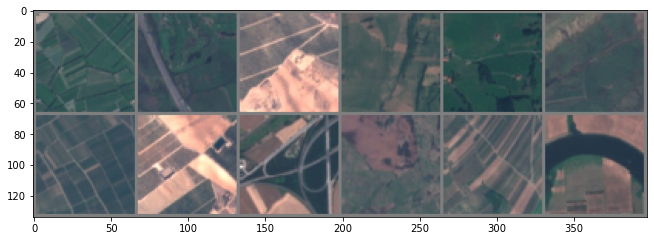

In [107]:
show_misclassified_images(misclassifiedLabels1)

In [108]:
print("Total Misclassified Images:", len(misclassifiedLabels1))

Total Misclassified Images: 1178


In [109]:
misclassified_images_per_labels1, label_prediction_accuracy1 = count_misclassified_images_per_label(confusion_matrix_report1)

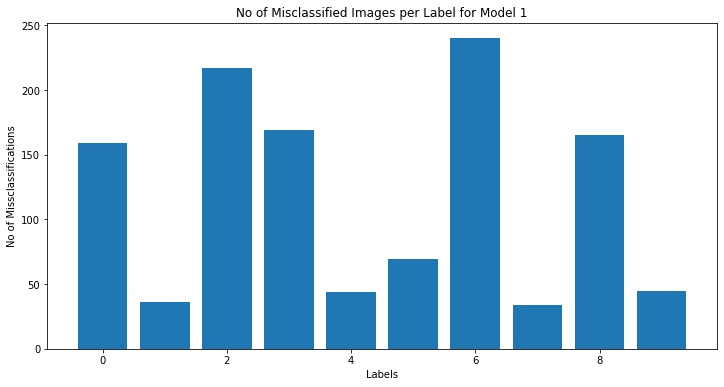

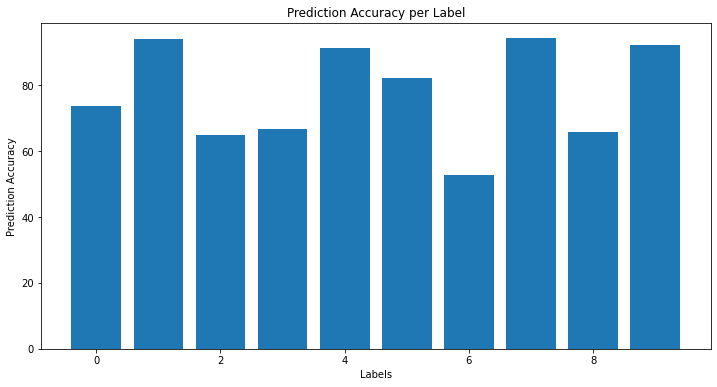

In [110]:
plot_misclassified_images_per_labels(misclassified_images_per_labels1, label_prediction_accuracy1, "No of Misclassified Images per Label for Model 1",
                                     "Prediction Accuracy per Label", labels)

In [111]:
low_accuracy_labels = [2, 3, 6, 8]

In [112]:
top_3_mislabeled1 = top_misclassified_predicted_labels(confusion_matrix_report1, low_accuracy_labels)

In [113]:
list_top_3_mislabeled_count(low_accuracy_labels, top_3_mislabeled1, confusion_matrix_report1)

For label 2, HerbaceousVegetation, top three misclassified labels are:
---> Mislabeled: 3 Highway
Count: 55
---> Mislabeled: 6 PermanentCrop
Count: 45
---> Mislabeled: 7 Residential
Count: 38

For label 3, Highway, top three misclassified labels are:
---> Mislabeled: 8 River
Count: 63
---> Mislabeled: 7 Residential
Count: 26
---> Mislabeled: 6 PermanentCrop
Count: 23

For label 6, PermanentCrop, top three misclassified labels are:
---> Mislabeled: 3 Highway
Count: 96
---> Mislabeled: 2 HerbaceousVegetation
Count: 79
---> Mislabeled: 5 Pasture
Count: 22

For label 8, River, top three misclassified labels are:
---> Mislabeled: 3 Highway
Count: 78
---> Mislabeled: 5 Pasture
Count: 24
---> Mislabeled: 1 Forest
Count: 20



/tmp/ipykernel_148/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_148/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


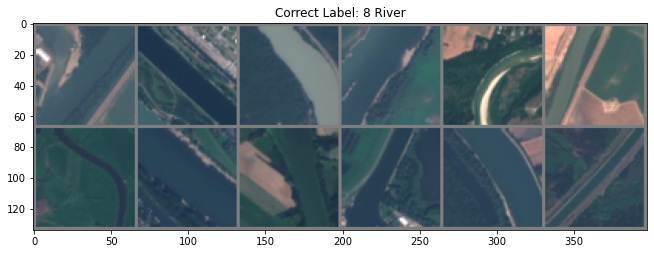

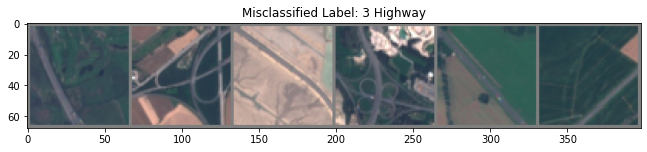

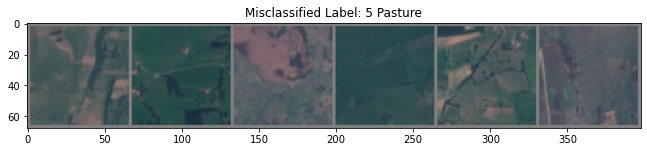

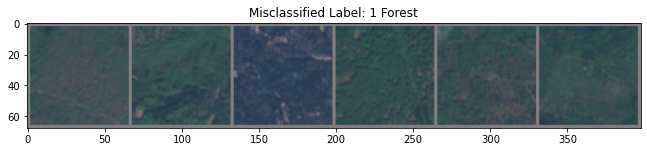

In [114]:
show_misclassified_images_per_labels(8, top_3_mislabeled1, misclassifiedLabels1)

/tmp/ipykernel_148/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_148/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


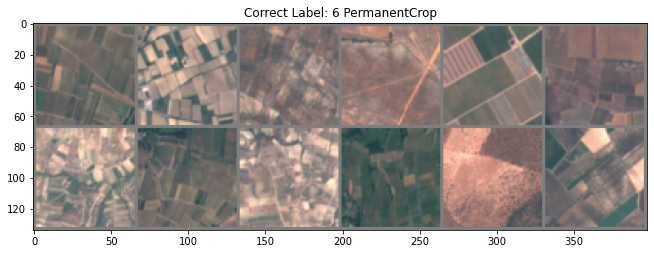

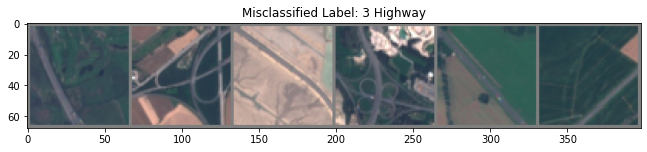

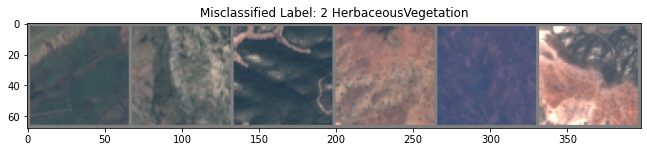

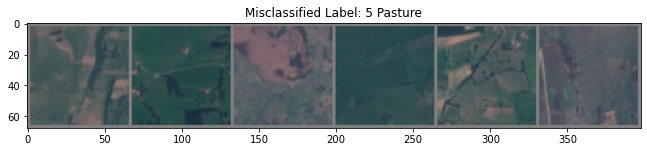

In [115]:
show_misclassified_images_per_labels(6, top_3_mislabeled1, misclassifiedLabels1)

/tmp/ipykernel_148/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_148/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


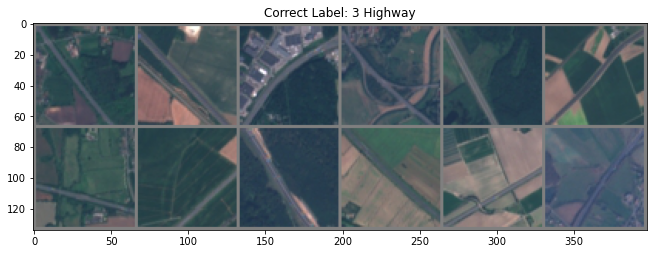

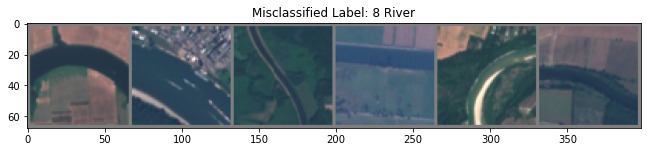

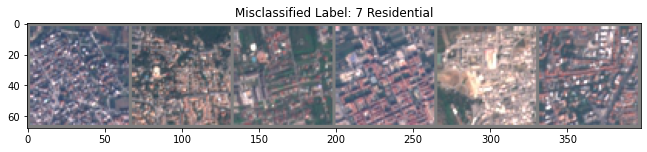

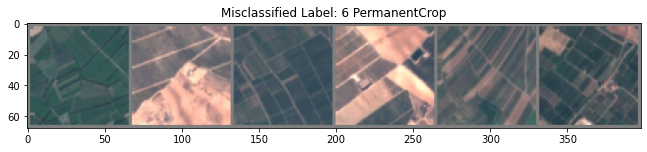

In [116]:
show_misclassified_images_per_labels(3, top_3_mislabeled1, misclassifiedLabels1)

/tmp/ipykernel_148/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_148/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


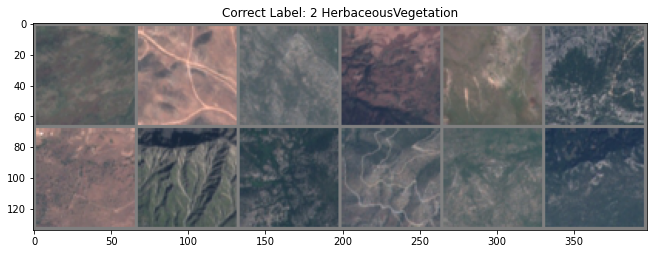

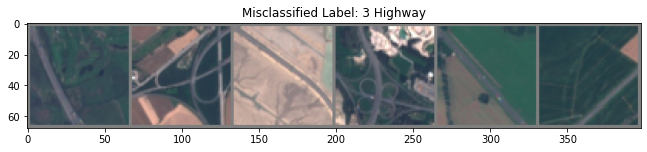

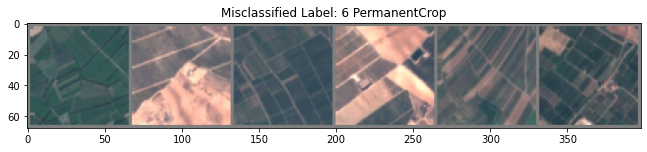

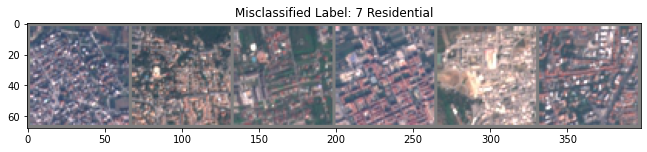

In [117]:
show_misclassified_images_per_labels(2, top_3_mislabeled1, misclassifiedLabels1)

## Model 2

/tmp/ipykernel_148/1957724292.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  miss = torch.tensor(misclassifiedLabels[i]['correctLabel']).cpu().reshape(1)
/tmp/ipykernel_148/1957724292.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correctLabel = torch.tensor(misclassifiedLabels[i]['predicted']).cpu().reshape(1)
/tmp/ipykernel_148/1957724292.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabels[i]['image']).cpu().reshape(1, 3, 64, 64)


Correct Labels:   tensor([5., 4., 6., 2., 2., 3., 4., 2., 8., 0., 1., 1.])
Predicted Labels: tensor([6., 3., 2., 6., 0., 8., 3., 6., 3., 6., 8., 9.])

Correct Label: 5.0 --> Pasture
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 4.0 --> Industrial
Predicted Label: 3.0 --> Highway

Correct Label: 6.0 --> PermanentCrop
Predicted Label: 2.0 --> HerbaceousVegetation

Correct Label: 2.0 --> HerbaceousVegetation
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 2.0 --> HerbaceousVegetation
Predicted Label: 0.0 --> AnnualCrop

Correct Label: 3.0 --> Highway
Predicted Label: 8.0 --> River

Correct Label: 4.0 --> Industrial
Predicted Label: 3.0 --> Highway

Correct Label: 2.0 --> HerbaceousVegetation
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 8.0 --> River
Predicted Label: 3.0 --> Highway

Correct Label: 0.0 --> AnnualCrop
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 1.0 --> Forest
Predicted Label: 8.0 --> River

Correct Label: 1.0 --> Forest
Predicted Label: 

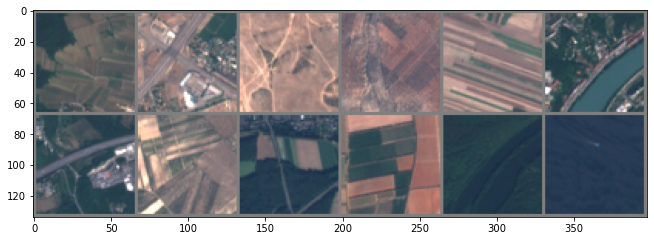

In [118]:
show_misclassified_images(misclassifiedLabels2)

In [119]:
print("Total Misclassified Images:", len(misclassifiedLabels2))

Total Misclassified Images: 616


In [120]:
misclassified_images_per_labels2, label_prediction_accuracy2 = count_misclassified_images_per_label(confusion_matrix_report2)

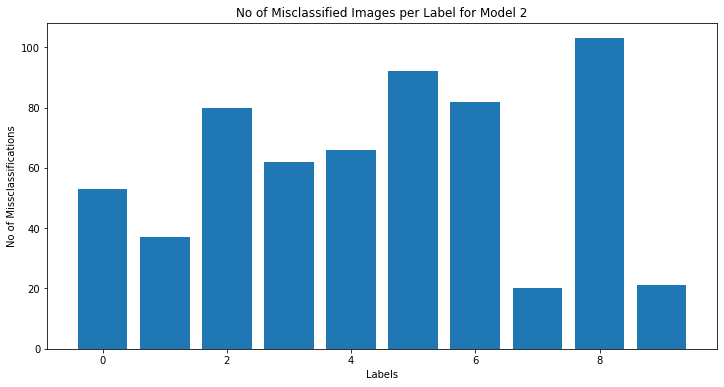

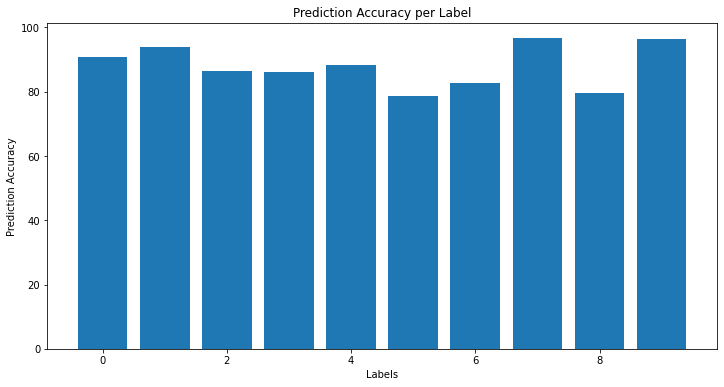

In [121]:
plot_misclassified_images_per_labels(misclassified_images_per_labels2, label_prediction_accuracy2, "No of Misclassified Images per Label for Model 2",
                                     "Prediction Accuracy per Label", labels)

In [122]:
low_accuracy_labels = [3, 5, 6, 8]

In [123]:
top_3_mislabeled2 = top_misclassified_predicted_labels(confusion_matrix_report2, low_accuracy_labels)

In [124]:
list_top_3_mislabeled_count(low_accuracy_labels, top_3_mislabeled2, confusion_matrix_report2)

For label 3, Highway, top three misclassified labels are:
---> Mislabeled: 8 River
Count: 19
---> Mislabeled: 6 PermanentCrop
Count: 18
---> Mislabeled: 2 HerbaceousVegetation
Count: 12

For label 5, Pasture, top three misclassified labels are:
---> Mislabeled: 8 River
Count: 20
---> Mislabeled: 6 PermanentCrop
Count: 18
---> Mislabeled: 2 HerbaceousVegetation
Count: 17

For label 6, PermanentCrop, top three misclassified labels are:
---> Mislabeled: 0 AnnualCrop
Count: 29
---> Mislabeled: 2 HerbaceousVegetation
Count: 25
---> Mislabeled: 3 Highway
Count: 16

For label 8, River, top three misclassified labels are:
---> Mislabeled: 3 Highway
Count: 42
---> Mislabeled: 2 HerbaceousVegetation
Count: 21
---> Mislabeled: 0 AnnualCrop
Count: 15



/tmp/ipykernel_148/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_148/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


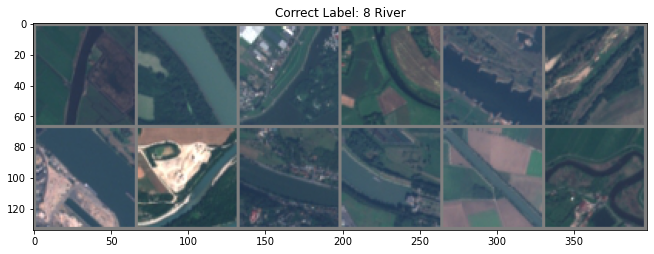

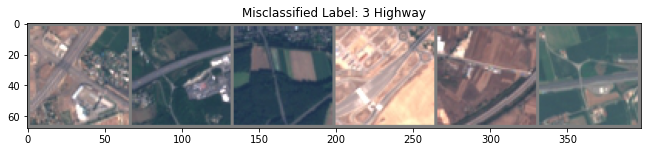

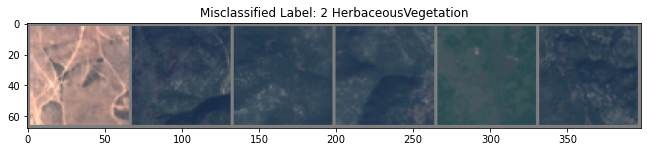

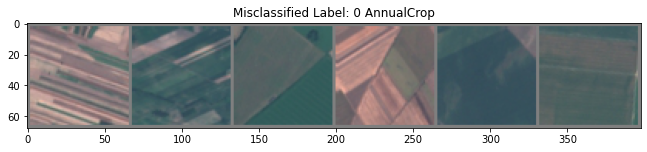

In [125]:
show_misclassified_images_per_labels(8, top_3_mislabeled2, misclassifiedLabels2)

/tmp/ipykernel_148/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_148/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


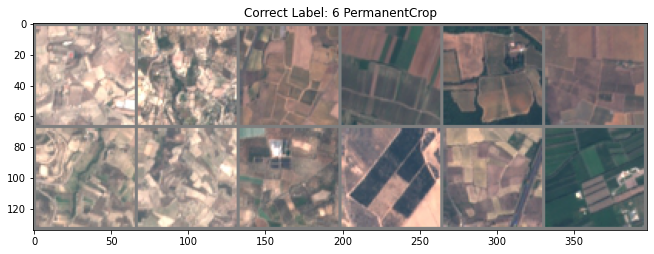

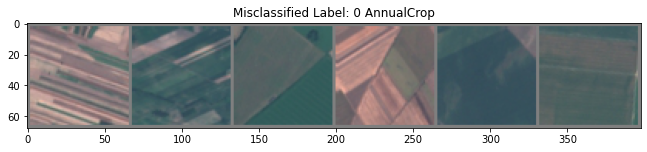

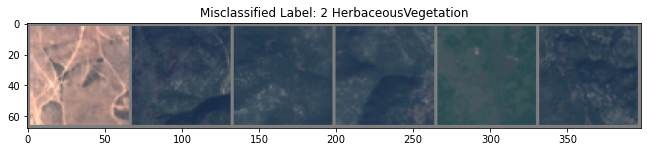

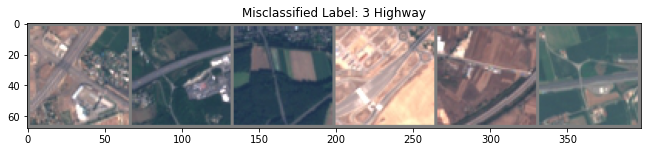

In [126]:
show_misclassified_images_per_labels(6, top_3_mislabeled2, misclassifiedLabels2)

/tmp/ipykernel_148/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_148/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


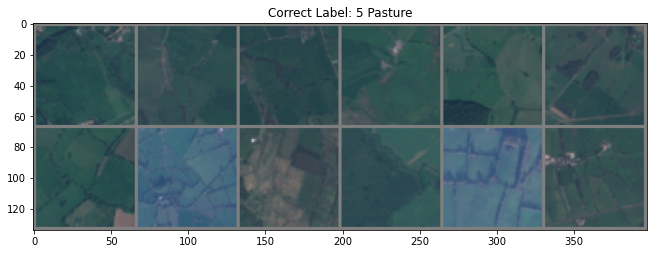

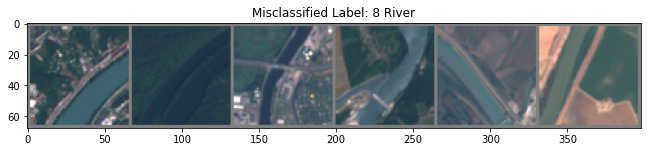

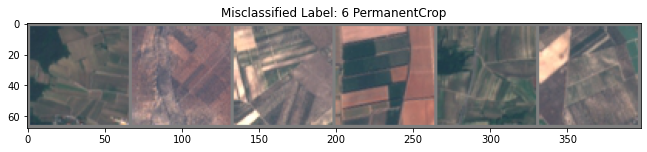

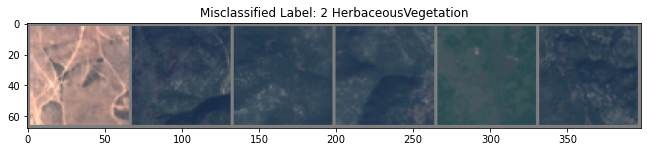

In [127]:
show_misclassified_images_per_labels(5, top_3_mislabeled2, misclassifiedLabels2)

/tmp/ipykernel_148/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_148/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


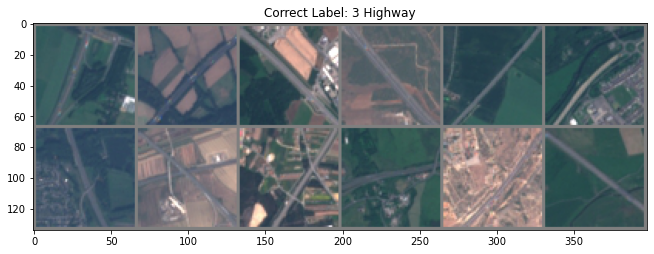

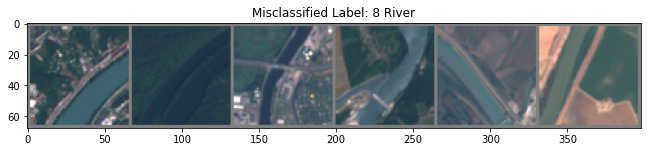

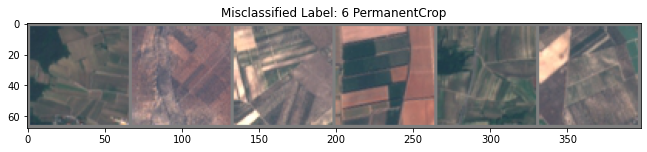

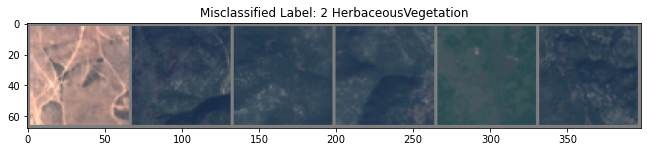

In [128]:
show_misclassified_images_per_labels(3, top_3_mislabeled2, misclassifiedLabels2)

## Model 3

/tmp/ipykernel_148/1957724292.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  miss = torch.tensor(misclassifiedLabels[i]['correctLabel']).cpu().reshape(1)
/tmp/ipykernel_148/1957724292.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correctLabel = torch.tensor(misclassifiedLabels[i]['predicted']).cpu().reshape(1)
/tmp/ipykernel_148/1957724292.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabels[i]['image']).cpu().reshape(1, 3, 64, 64)


Correct Labels:   tensor([0., 3., 6., 8., 3., 0., 1., 0., 0., 9., 3., 0.])
Predicted Labels: tensor([6., 6., 2., 2., 8., 5., 5., 2., 6., 0., 6., 8.])

Correct Label: 0.0 --> AnnualCrop
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 3.0 --> Highway
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 6.0 --> PermanentCrop
Predicted Label: 2.0 --> HerbaceousVegetation

Correct Label: 8.0 --> River
Predicted Label: 2.0 --> HerbaceousVegetation

Correct Label: 3.0 --> Highway
Predicted Label: 8.0 --> River

Correct Label: 0.0 --> AnnualCrop
Predicted Label: 5.0 --> Pasture

Correct Label: 1.0 --> Forest
Predicted Label: 5.0 --> Pasture

Correct Label: 0.0 --> AnnualCrop
Predicted Label: 2.0 --> HerbaceousVegetation

Correct Label: 0.0 --> AnnualCrop
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 9.0 --> SeaLake
Predicted Label: 0.0 --> AnnualCrop

Correct Label: 3.0 --> Highway
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 0.0 --> AnnualCrop
Predicted Label: 8.0 

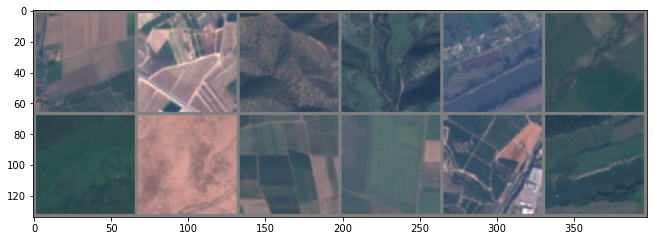

In [129]:
show_misclassified_images(misclassifiedLabels3)

In [130]:
print("Total Misclassified Images:", len(misclassifiedLabels3))

Total Misclassified Images: 454


In [131]:
misclassified_images_per_labels3, label_prediction_accuracy3 = count_misclassified_images_per_label(confusion_matrix_report3)

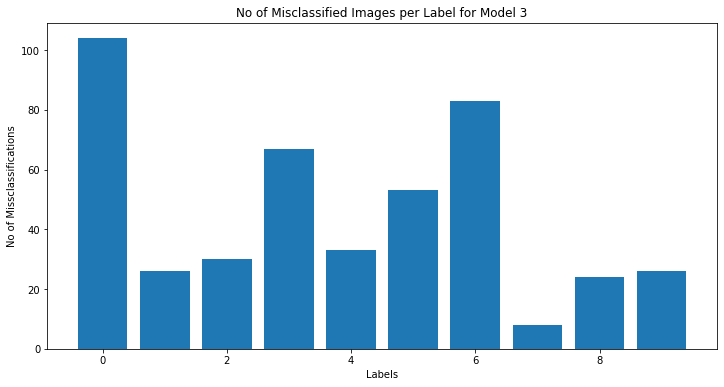

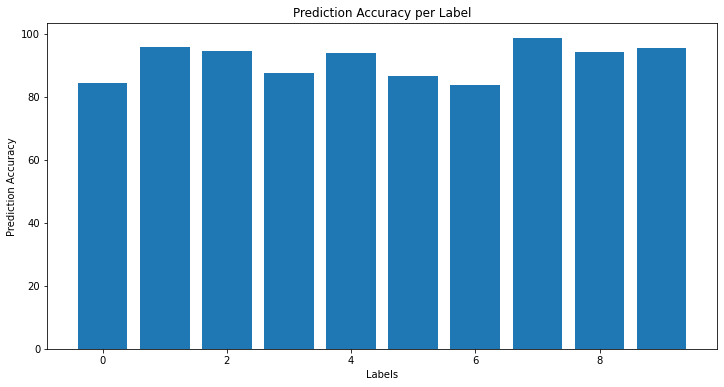

In [132]:
plot_misclassified_images_per_labels(misclassified_images_per_labels3, label_prediction_accuracy3, "No of Misclassified Images per Label for Model 3",
                                     "Prediction Accuracy per Label", labels)

In [133]:
low_accuracy_labels = [2, 3, 6, 8]

In [134]:
top_3_mislabeled3 = top_misclassified_predicted_labels(confusion_matrix_report3, low_accuracy_labels)

In [135]:
list_top_3_mislabeled_count(low_accuracy_labels, top_3_mislabeled3, confusion_matrix_report3)

For label 2, HerbaceousVegetation, top three misclassified labels are:
---> Mislabeled: 1 Forest
Count: 8
---> Mislabeled: 6 PermanentCrop
Count: 7
---> Mislabeled: 5 Pasture
Count: 5

For label 3, Highway, top three misclassified labels are:
---> Mislabeled: 8 River
Count: 32
---> Mislabeled: 6 PermanentCrop
Count: 19
---> Mislabeled: 4 Industrial
Count: 6

For label 6, PermanentCrop, top three misclassified labels are:
---> Mislabeled: 2 HerbaceousVegetation
Count: 59
---> Mislabeled: 5 Pasture
Count: 8
---> Mislabeled: 3 Highway
Count: 7

For label 8, River, top three misclassified labels are:
---> Mislabeled: 2 HerbaceousVegetation
Count: 8
---> Mislabeled: 0 AnnualCrop
Count: 5
---> Mislabeled: 6 PermanentCrop
Count: 4



/tmp/ipykernel_148/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_148/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


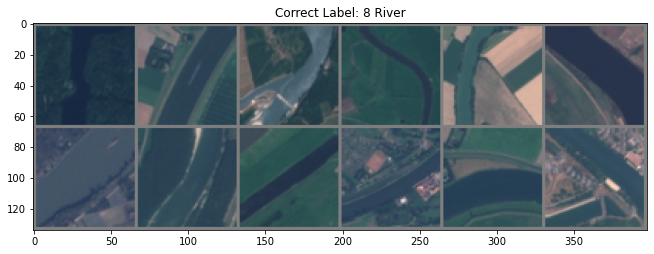

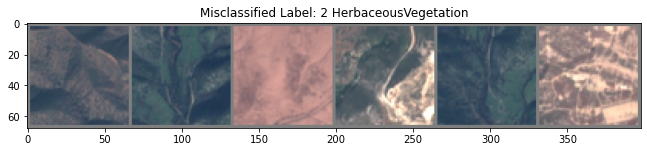

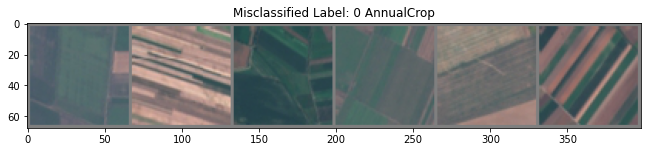

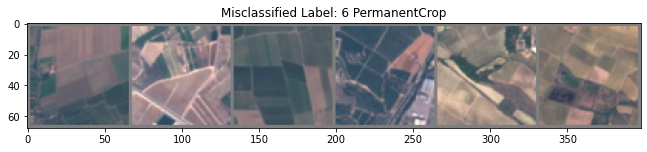

In [136]:
show_misclassified_images_per_labels(8, top_3_mislabeled3, misclassifiedLabels3)

/tmp/ipykernel_148/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_148/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


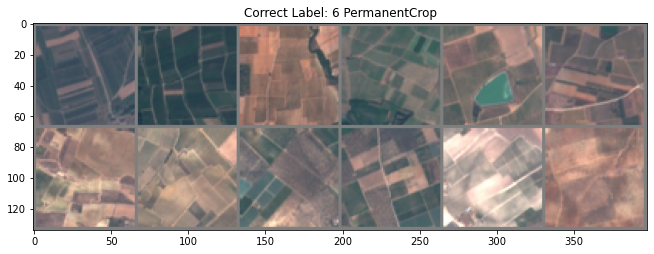

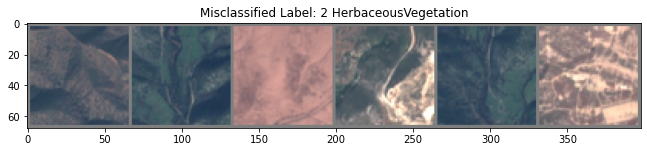

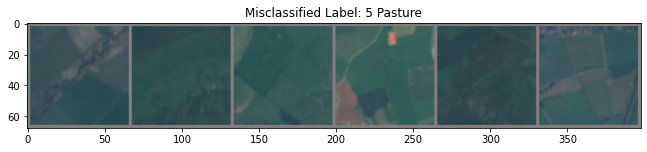

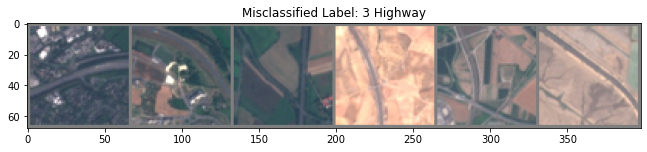

In [137]:
show_misclassified_images_per_labels(6, top_3_mislabeled3, misclassifiedLabels3)

/tmp/ipykernel_148/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_148/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


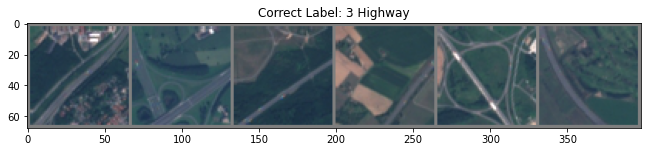

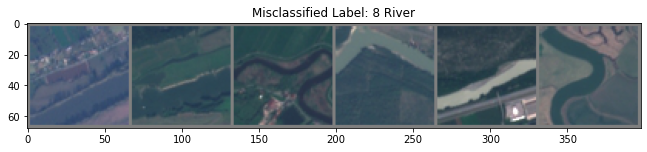

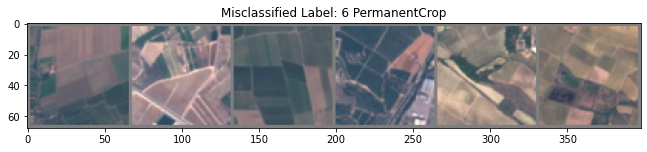

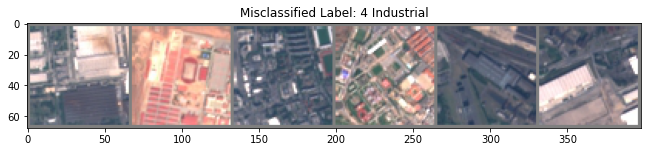

In [138]:
show_misclassified_images_per_labels(3, top_3_mislabeled3, misclassifiedLabels3)

/tmp/ipykernel_148/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_148/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


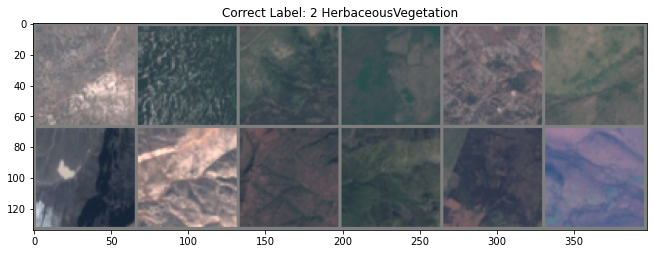

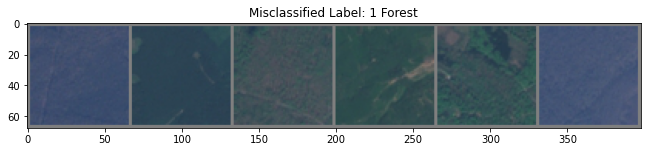

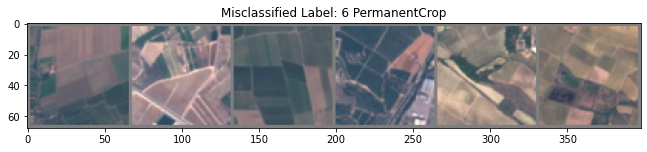

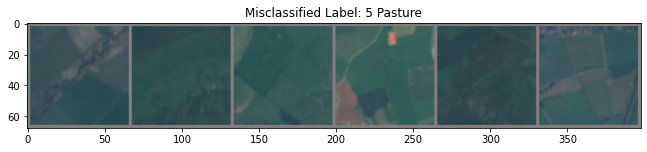

In [139]:
show_misclassified_images_per_labels(2, top_3_mislabeled3, misclassifiedLabels3)

In [141]:
import os

# Set proxy in case it's not already set in our environment before loading torchvision

os.environ['https_proxy'] = 'http://192.41.170.23:3128'
os.environ['http_proxy'] = 'http://192.41.170.23:3128'

In [40]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):
        
        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )        
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]        
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))
       
        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out 
    
class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        
        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )

      
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]        
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        
        scale_out = self.scale_process(torch.cat(scale_list, 1))
       
        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out
    

class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels, 
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels, 
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels, 
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)
        
        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)
        
        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))
        
        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y
        
        return x
    
class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels, 
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels, 
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        
    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        
        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)
        
        return p_add + i_add
    

class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels, 
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels, 
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        
    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        
        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)
        
        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels, 
                                          kernel_size=3, padding=1, bias=False)                  
                                )

        
    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)
    


In [42]:
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment
        
        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)
        
        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)
        
        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)
            
        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)
        
        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)           

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)
    
    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)
        
        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)
        
        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_
        
        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))
        
        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d
            
        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment: 
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_      

def get_seg_model(cfg, imgnet_pretrained):
    
    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)
    
    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict'] 
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)
    
    return model

def get_pred_model(name, num_classes):
    
    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)
    
    return model

if __name__ == '__main__':
    
    # Comment batchnorms here and in model_utils before testing speed since the batchnorm could be integrated into conv operation
    # (do not comment all, just the batchnorm following its corresponding conv layer)
    device = torch.device('cuda')
    model = get_pred_model(name='pidnet_s', num_classes=19)
    model.eval()
    model.to(device)
    iterations = None
    
    input = torch.randn(1, 3, 1024, 2048).cuda()
    with torch.no_grad():
        for _ in range(10):
            model(input)
    
        if iterations is None:
            elapsed_time = 0
            iterations = 100
            while elapsed_time < 1:
                torch.cuda.synchronize()
                torch.cuda.synchronize()
                t_start = time.time()
                for _ in range(iterations):
                    model(input)
                torch.cuda.synchronize()
                torch.cuda.synchronize()
                elapsed_time = time.time() - t_start
                iterations *= 2
            FPS = iterations / elapsed_time
            iterations = int(FPS * 6)
    
        print('=========Speed Testing=========')
        torch.cuda.synchronize()
        torch.cuda.synchronize()
        t_start = time.time()
        for _ in range(iterations):
            model(input)
        torch.cuda.synchronize()
        torch.cuda.synchronize()
        elapsed_time = time.time() - t_start
        latency = elapsed_time / iterations * 1000
    torch.cuda.empty_cache()
    FPS = 1000 / latency
    print(FPS)
    

=========Speed Testing=========
57.14579571319399


In [43]:
pid_model = PIDNet().to(device)

In [44]:
print(pid_model)

PIDNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [47]:
random_image = torch.rand((50, 3, 64, 64)).to(device)
out = pid_model(random_image)

In [48]:
out

[tensor([[[[-4.1063e-02,  3.3690e+00,  2.2477e+00,  ...,  1.8121e+00,
             2.7514e-01,  8.3396e-01],
           [-1.0502e-01,  4.4837e+00,  2.8774e-01,  ...,  1.7454e+00,
            -8.9583e-01,  8.0486e-03],
           [-3.2350e-01, -9.5443e-01,  4.8812e+00,  ..., -7.6073e-01,
             4.1516e+00, -6.8961e-01],
           ...,
           [ 2.7061e+00, -1.0797e+00,  1.4722e+00,  ...,  1.9694e+00,
             3.1215e+00,  1.5519e+00],
           [ 4.6517e-01,  3.3048e+00,  1.7725e+00,  ...,  3.0570e+00,
             3.5905e+00,  1.8026e+00],
           [ 6.0782e-01,  8.5106e-01, -1.1333e+00,  ...,  6.5347e-02,
             1.6459e+00,  1.2816e+00]],
 
          [[-4.0877e+00, -5.3814e+00,  2.0292e-01,  ..., -2.4089e+00,
            -6.2249e-01, -1.4006e+00],
           [-2.6125e+00, -1.1951e+00,  8.0186e-01,  ..., -3.1137e+00,
            -1.5114e+00, -3.8161e-02],
           [-1.4016e+00,  6.0663e-01,  5.4350e-01,  ..., -5.8641e-01,
            -6.2643e-01, -1.0911e+00],


In [50]:
J_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pid_model.parameters(), lr=0.001)

In [51]:
pid_filepath = 'pid_model.pt'

In [55]:
train_losses2, avg_train_losses_per_epoch2, train_accs2, avg_train_accs_per_epoch2, training_time2, training_time_per_epoch2, val_losses2, val_accs2 = train(pid_model, optimizer, J_fn, pid_filepath)

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not list

# Transfer Learning

## Alexnet

In [30]:
!pip install --upgrade torch torchvision

In [ ]:
!wget https://download.pytorch.org/models/alexnet-owt-7be5be79.pth

--2022-12-03 18:11:25--  https://download.pytorch.org/models/alexnet-owt-7be5be79.pth
Resolving download.pytorch.org (download.pytorch.org)... 65.9.164.114, 65.9.164.21, 65.9.164.22, ...
Connecting to download.pytorch.org (download.pytorch.org)|65.9.164.114|:443... failed: Connection timed out.
Connecting to download.pytorch.org (download.pytorch.org)|65.9.164.21|:443... failed: Connection timed out.
Connecting to download.pytorch.org (download.pytorch.org)|65.9.164.22|:443... failed: Connection timed out.
Connecting to download.pytorch.org (download.pytorch.org)|65.9.164.15|:443... failed: Connection timed out.
Connecting to download.pytorch.org (download.pytorch.org)|2600:9000:203f:fc00:d:607e:4540:93a1|:443... failed: Cannot assign requested address.
Connecting to download.pytorch.org (download.pytorch.org)|2600:9000:203f:6600:d:607e:4540:93a1|:443... failed: Cannot assign requested address.
Connecting to download.pytorch.org (download.pytorch.org)|2600:9000:203f:b000:d:607e:4540:93

In [ ]:
curl -O

In [1]:
import urllib.request
url = "https://download.pytorch.org/models/"
filename='alexnet-owt-7be5be79.pth'
urllib.request.urlretrieve(url, filename)

URLError: <urlopen error [Errno 99] Cannot assign requested address>

In [ ]:
mv alexnet-owt-7be5be79.pth ~/.torch/models/

In [1]:
import torchvision

In [ ]:
from torchvision import models
#from torchvision.models import AlexNet_Weights

In [34]:
#alexnet = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1).to(device)

In [ ]:
alexnet = models.alexnet(pretrained=True)
alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/st122876/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


URLError: <urlopen error [Errno 99] Cannot assign requested address>

In [152]:
for param in alexnet.parameters():
    param.requires_grad=False 

alexnet.classifier = nn.Sequential(
    nn.Linear(9216, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 700),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(700, 400),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(400, 10)
)

alexnet = alexnet.to(device)

In [153]:
random_image = torch.rand((50, 3, 100, 100)).to(device)
out = alexnet(random_image)
print(out.shape)

torch.Size([50, 10])


In [154]:
J_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.parameters(), lr=0.001)

In [157]:
filepath4 = 'alexnetbestModelPara.pt'

## Train

In [158]:
train_lossesTF, avg_train_losses_per_epochTF, train_accsTF, avg_train_accs_per_epochTF, training_timeTF, training_time_per_epochTF, val_lossesTF, val_accsTF = train(alexnet, optimizer, J_fn, filepath4, 20)

Epoch: 1 - Batch: 64 - Train Loss: 0.67 - Train Acc: 80.74 - Total Time: 0.01s
Epoch: 1 - Batch: 128 - Train Loss: 0.57 - Train Acc: 81.73 - Total Time: 0.01s
Epoch: 1 - Batch: 192 - Train Loss: 0.52 - Train Acc: 81.60 - Total Time: 0.01s
Epoch: 1 - Batch: 256 - Train Loss: 0.53 - Train Acc: 81.61 - Total Time: 0.01s
++++++End of Epoch 1 ++++++ Avg Train Loss: 0.57 - Avg Train Acc: 81.55 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 0.58 - Val Acc: 81.00
Epoch: 2 - Batch: 64 - Train Loss: 0.62 - Train Acc: 82.74 - Total Time: 0.01s
Epoch: 2 - Batch: 128 - Train Loss: 0.58 - Train Acc: 83.09 - Total Time: 0.01s
Epoch: 2 - Batch: 192 - Train Loss: 0.56 - Train Acc: 83.27 - Total Time: 0.01s
Epoch: 2 - Batch: 256 - Train Loss: 0.34 - Train Acc: 83.27 - Total Time: 0.01s
++++++End of Epoch 2 ++++++ Avg Train Loss: 0.53 - Avg Train Acc: 83.22 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 0.54 - Val Acc: 83.06
Epoch: 3 - Batch: 64 - Train Loss: 0.36 - Train Acc: 84.08 - T

## Plotting Loss

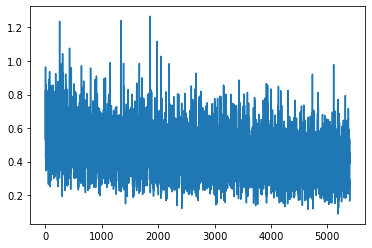

In [160]:
plt.plot(torch.Tensor(train_lossesTF).cpu())
#plt.plot(train_lossesTF)

In [161]:
def plotLoss(trainingLoss, valLoss):
    plt.plot(trainingLoss)
    plt.plot(valLoss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training Loss", "Val Loss"])

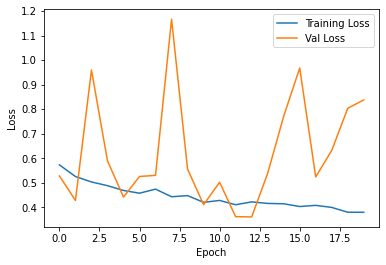

In [162]:
#plotLoss(avg_train_losses_per_epochTF, val_lossesTF)

plotLoss(torch.Tensor(avg_train_losses_per_epochTF).cpu(), torch.Tensor(val_lossesTF).cpu())

## Plotting accuracy

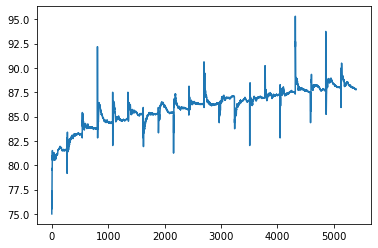

In [163]:
plt.plot(torch.tensor(train_accsTF).cpu())

In [164]:
def plotAccuracy(trainingAcc, valAcc):
    plt.plot(trainingAcc)
    plt.plot(valAcc)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(["Training Accuracy", "Val Accuracy"])

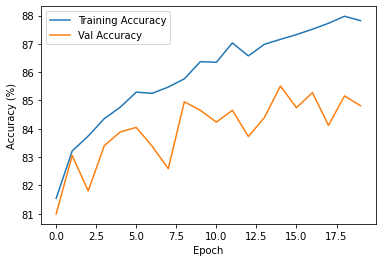

In [165]:
plotAccuracy(torch.Tensor(avg_train_accs_per_epochTF).cpu(), torch.Tensor(val_accsTF).cpu())

## Plotting Training Time

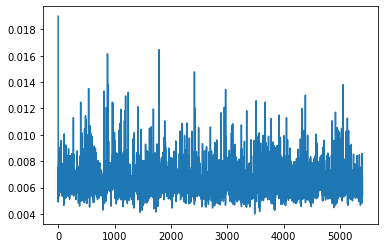

In [166]:
plt.plot(torch.Tensor(training_timeTF).cpu())

In [167]:
def plotTrainingTime(training_time):
    plt.plot(training_time)
    plt.xlabel("Epoch")
    plt.ylabel("Training Time (s)")

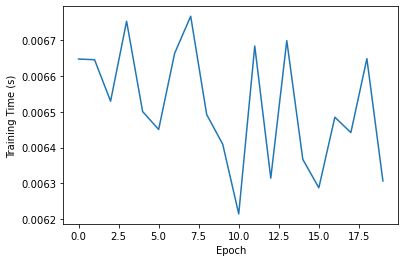

In [168]:
plotTrainingTime(torch.Tensor(training_time_per_epochTF).cpu())

In [169]:
saveObject = {
    'train_losses': train_lossesTF,
    'avg_train_losses_per_epoch': avg_train_losses_per_epochTF,
    'train_accs': train_accsTF,
    'avg_train_accs_per_epoch': avg_train_accs_per_epochTF,
    'training_time': training_timeTF,
    'training_time_per_epoch': training_time_per_epochTF,
    'val_losses': val_lossesTF,
    'val_accs': val_accsTF
}

torch.save(saveObject, 'alexnetTrainingHist.pt')

# Resnet

In [171]:
resnet = models.resnet18(pretrained=True).to(device)
resnet

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/st122574/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [173]:
for param in resnet.parameters():
    param.requires_grad=False #this is essentially freezing all the weights

resnet.fc = nn.Linear(512, 10)

resnet = resnet.to(device)

In [175]:
random_image = torch.rand((50, 3, 64, 64)).to(device)
out = resnet(random_image)
print(out.shape)

torch.Size([50, 10])


In [176]:
J_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

In [177]:
filepath5 = 'resnetbestModelPara.pt'

In [178]:
train_lossesTF2, avg_train_losses_per_epochTF2, train_accsTF2, avg_train_accs_per_epochTF2, training_timeTF2, training_time_per_epochTF2, val_lossesTF2, val_accsTF2 = train(resnet, optimizer, J_fn, filepath5, 20)

Epoch: 1 - Batch: 64 - Train Loss: 1.00 - Train Acc: 51.20 - Total Time: 0.01s
Epoch: 1 - Batch: 128 - Train Loss: 0.96 - Train Acc: 63.48 - Total Time: 0.01s
Epoch: 1 - Batch: 192 - Train Loss: 0.61 - Train Acc: 68.95 - Total Time: 0.01s
Epoch: 1 - Batch: 256 - Train Loss: 0.71 - Train Acc: 72.02 - Total Time: 0.01s
++++++End of Epoch 1 ++++++ Avg Train Loss: 0.92 - Avg Train Acc: 72.52 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 0.62 - Val Acc: 81.46
Epoch: 2 - Batch: 64 - Train Loss: 0.40 - Train Acc: 82.25 - Total Time: 0.01s
Epoch: 2 - Batch: 128 - Train Loss: 0.50 - Train Acc: 82.68 - Total Time: 0.01s
Epoch: 2 - Batch: 192 - Train Loss: 0.71 - Train Acc: 82.64 - Total Time: 0.01s
Epoch: 2 - Batch: 256 - Train Loss: 0.47 - Train Acc: 82.97 - Total Time: 0.01s
++++++End of Epoch 2 ++++++ Avg Train Loss: 0.54 - Avg Train Acc: 83.15 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 0.52 - Val Acc: 83.70
Epoch: 3 - Batch: 64 - Train Loss: 0.56 - Train Acc: 84.08 - T